In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches

In [2]:
# Read in 2018 and 2017 survey datasets, we only need the programming language responses
df_2018 = pd.read_csv("developer_survey_2018/survey_results_public.csv", low_memory = False)[["LanguageWorkedWith", "Country"]]
df_2017 = pd.read_csv("developer_survey_2017/survey_results_public.csv", low_memory = False)[["HaveWorkedLanguage", "Country"]]

In [3]:
# US only
df_2018 = df_2018[df_2018["Country"] ==  "United States"]
df_2017 = df_2017[df_2017["Country"] ==  "United States"]

# Drop NA values
df_2018 = df_2018.dropna()
df_2017 = df_2017.dropna()

# Only need these columns
df_2018 = df_2018["LanguageWorkedWith"]
df_2017 = df_2017["HaveWorkedLanguage"]

In [4]:
# Build list of unique languages across both survey years
languages_2018 = [l for sublist in df_2018.map(lambda x: x.split("; ")) for l in sublist]
languages_2018 = [l for sublist in languages_2018 for l in sublist.split(";")]
languages_2017 = [l for sublist in df_2017.map(lambda x: x.split("; ")) for l in sublist]
languages_2017 = [l for sublist in languages_2017 for l in sublist.split(";")]

languages = list(np.unique(languages_2018 + languages_2017))

In [5]:
# Convert series to dataframes, rename column
df_2018 = pd.DataFrame(data = df_2018)
df_2017 = pd.DataFrame(data = df_2017)

df_2018.columns = ["Languages"]
df_2017.columns = ["Languages"]

In [6]:
# Construct dummy for each language, True if respondent uses the langauge
for lang in languages:
    df_2018[lang] = df_2018.apply(
        lambda row: True if sum(
            [lang == x for x in row["Languages"].split(";")]) > 0 else False, axis = 1)
    df_2017[lang] = df_2017.apply(
        lambda row: True if sum(
            [lang == x for x in row["Languages"].split("; ")]) > 0 else False, axis = 1)

In [7]:
# Calculate popularity of each language
share_2018 = pd.DataFrame(
    columns = ["Language", "Share_2018"], data = list(
        zip([lang for lang in languages],
            [df_2018[lang].sum()/len(df_2018.values) for lang in languages])))
share_2017 = pd.DataFrame(
    columns = ["Language", "Share_2017"], data = list(
        zip([lang for lang in languages],
            [df_2017[lang].sum()/len(df_2017.values) for lang in languages])))

In [8]:
# Join the 2018 and 2017 datasets for ease of use
growth_share = pd.merge(left = share_2018, right = share_2017, how = "left",
                 left_on = "Language", right_on = "Language")

In [9]:
# Remove any languages that were not present in one or both surveys
growth_share = growth_share[(growth_share["Share_2018"] != 0) & (growth_share["Share_2017"] != 0)]

In [10]:
# Calculate growth and relative market share of each language
growth_share.loc[:, "Growth"] = growth_share["Share_2018"] / growth_share["Share_2017"] - 1
growth_share.loc[:, "Relative_Share_2018"] = growth_share["Share_2018"] / max(growth_share["Share_2018"])

# Remove languages with less than 2.5% relative popularity in 2018
growth_share = growth_share[growth_share["Relative_Share_2018"] > .025]

# Sort by relative market share, useful later
growth_share.sort_values("Relative_Share_2018", inplace = True)
growth_share.reset_index(drop = True, inplace = True)

In [11]:
# Axes ranges and quadrant cuts
ymin = -0.2
ymax = 1.6
xcut = growth_share["Relative_Share_2018"].median()
ycut = growth_share["Growth"].median()

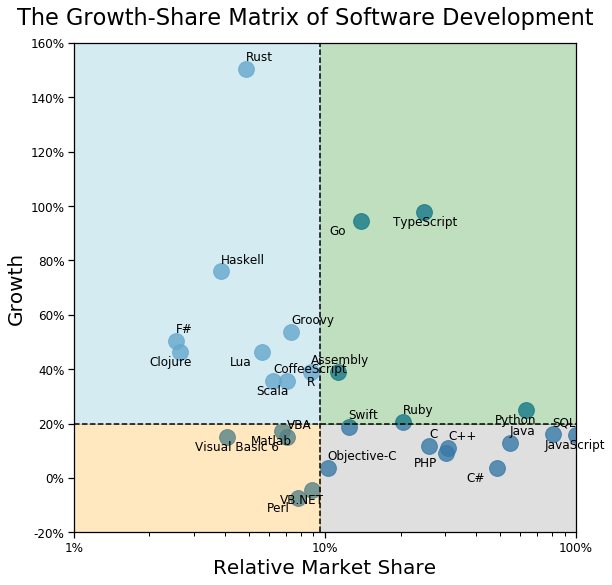

In [12]:
# Plot the growth-share matrix
sns.set_context("notebook")
plt.subplots(figsize=(9,9))

gsmatrix = sns.regplot(x = "Relative_Share_2018", y = "Growth", fit_reg = False,
                       scatter_kws= {"s": 250}, data = growth_share)

ttl = gsmatrix.set_title("The Growth-Share Matrix of Software Development", fontsize = 22.5)
ttl.set_position([0.46,1.025])
gsmatrix.set_xlabel(xlabel = "Relative Market Share", fontsize = 20)
gsmatrix.set_ylabel(ylabel = "Growth", fontsize = 20)
gsmatrix.tick_params(labelsize = "medium")
gsmatrix.set(xscale = "log", xlim = (0.01, 1), ylim = (ymin, ymax))
gsmatrix.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
gsmatrix.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))

plt.axvline(x = xcut, color = "black", linestyle = "--")
plt.axhline(y = ycut, color = "black", linestyle = "--")

gsmatrix.add_patch(patches.Rectangle((xcut, ymin), 1 - xcut, 0 - ymin + ycut,
                                     alpha = 0.25, color = "grey"))
gsmatrix.add_patch(patches.Rectangle((xcut, ycut), 1 - xcut, ymax - ycut,
                                     alpha = 0.25, color = "green"))
gsmatrix.add_patch(patches.Rectangle((0.01, ycut), xcut - 0.01, ymax - ycut,
                                     alpha = 0.5, color = "lightblue"))
gsmatrix.add_patch(patches.Rectangle((0.01, ymin), xcut - 0.01, 0 - ymin + ycut,
                                     alpha = 0.25, color = "orange"))

for label in growth_share.index:
    if label % 2 == 0:
        gsmatrix.text(growth_share["Relative_Share_2018"][label],
                      growth_share["Growth"][label] + 0.03,
                      growth_share["Language"][label],
                      horizontalalignment='left', size='medium', color='black')
    else:
        gsmatrix.text(growth_share["Relative_Share_2018"][label]*.75,
                      growth_share["Growth"][label] - 0.05,
                      growth_share["Language"][label],
                      horizontalalignment='left', size='medium', color='black')